# 01 Simulate master LCs: pure DRW

- span very long baseline, eg. 40 years (start of SDSS in 1998 to 2038) . This is more than 10 tau  up to (40*365)/10 = 1200 days.

- for master light curves, all have identical sampling times, which are stored in a single file t_true.txt

- master light curves all oscillate around 0 mean. The desired true flux / magnitude can be added later to the mean.

- master light curves have no photometric error (since it's the ideal underlying process). It would be added at the "observation" stage. 

- we first simulate pure DRW. Each combination of tau / sfinf has 1000 realizations and is stored as a single .npy file . For 100 values of tau and 100 values of sfinf,  this is 1e(2+2+3) = 1e7 light curves. The values of tau grid are decided based on the total experiment baseline - we probe from 0.01 to 15 times the baseline.

- to each simulated pure DRW we add 100 combinatios of sinusoid / tau . This results in 1e9 light curves


- based on the idea here https://docs.google.com/document/d/1gIgO-4UzGMs_sCLrzvXrWpWnjF6Z4dK4DMfQvWSTZbo/edit?usp=sharing 

In [1]:
import os 
import pandas as pd 
import numpy as np 

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join

import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


In [2]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag

In [12]:
t_min = 0
t_max = 40*365.
dt = 0.25 # 1/4*24hrs = 6hrs - that's 4 obs per day
t = np.arange(t_min, t_max, dt)
np.savetxt('t_true.txt', t, )

Show what it'll look like:

Text(0.5, 1.0, '$\\tau = $100d, SF$_{\\infty}$=0.2mag')

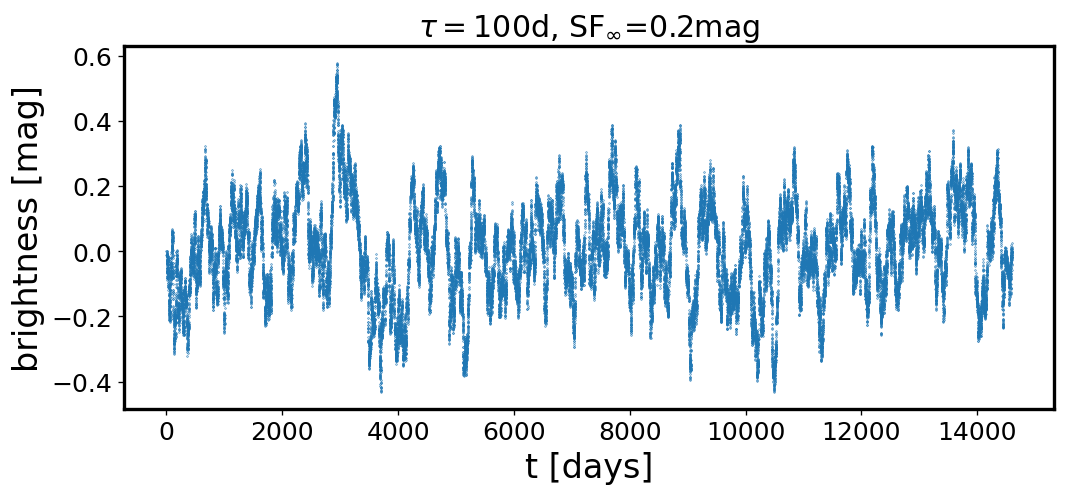

In [53]:
# first pure DRW 
sfinf = 0.2 # mag, span range 0.01 mag - 0.25 mag
tau = 100 # days, span range 10 to 10000 days 
y = sim_DRW_lightcurve(t, sfinf, tau, 0)

fig,ax = plt.subplots(1,1,figsize=(10,4), dpi=120)

ax.scatter(t,y,s=0.1)
ax.set_xlabel('t [days]')
ax.set_ylabel('brightness [mag]')
ax.set_title(r'$\tau = $'+str(tau)+'d, '+r'SF$_{\infty}$='+str(sfinf)+'mag')

In [59]:
sfinf_grid = np.linspace(0.01, 0.25, 100)

In [61]:
len(sfinf_grid)

100

In [27]:
sfinf_grid = np.linspace(0.01, 0.25, 100)

# instead of doing linear space for tau,
# we do logarithmic space, just like in Fig.2
# tau_grid = np.linspace(10,1000, 100) 

rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)
t_exp = max(t) - min(t) # days 
tau_grid = rho_grid * t_exp

In [ ]:
np.savetxt('tau_grid.txt', tau_grid)
np.savetxt('sfinf_grid.txt', sfinf_grid)

In [ ]:
from tqdm import tqdm
 
for i in tqdm(range(len(sfinf_grid)), desc="SFinf grid"): 
    sfinf = sfinf_grid[i]
    for j in tqdm(range(len(tau_grid)), desc="tau grid"):
        tau = tau_grid[j]
        sim = {} # new storage dict for each combination of tau, sfinf
        for k in range(10):
            sim[k] = sim_DRW_lightcurve(t, sfinf, tau, 0)
        np.save(f'LC_{str(i).zfill(3)}_{str(j).zfill(3)}',sim) 
        